In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import io
import json

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.debugging.set_log_device_placement(True)

In [4]:
raw = pd.read_csv('news_summary_more.csv',encoding='iso-8859-1')

In [5]:
pre1 =  raw.iloc[:,0:2].copy()

In [6]:
pre = pd.DataFrame()
pre['text'] = pre1['text']
pre['summary'] = pre1['headlines']

**Seq2Seq LSTM Modelling**
![final.jpg](attachment:final.jpg)

In [7]:
pre['text'][:10]

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
5    Pakistani singer Rahat Fateh Ali Khan has deni...
6    India recorded their lowest ODI total in New Z...
7    Weeks after ex-CBI Director Alok Verma told th...
8    Andhra Pradesh CM N Chandrababu Naidu has said...
9    Congress candidate Shafia Zubair won the Ramga...
Name: text, dtype: object

> **Perform Data Cleansing**

In [8]:
import re

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row




In [9]:
brief_cleaning1 = text_strip(pre['text'])
brief_cleaning2 = text_strip(pre['summary'])

In [10]:
from time import time
import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 3.25 mins


In [11]:
t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.77 mins


In [12]:
text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [13]:
summary[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [14]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

In [15]:
text_count = []
summary_count = []

In [16]:
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [17]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

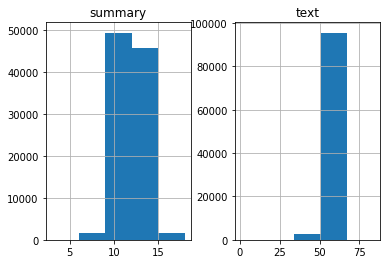

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

graph_df.hist(bins = 5)
plt.show()

In [19]:
#Check how much % of summary have 0-15 words
cnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

0.9977337628682635


In [20]:
#Check how much % of text have 0-100 words
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

1.0


In [21]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=100
max_summary_len=15

In [22]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [23]:
post_pre.head(2)

,summary,text
0,_START_ upgrad learner switches to career in m...,saurav kant an alumnus of upgrad and iiit-b pg...
1,_START_ delhi techie wins free food from swigg...,kunal shah credit card bill payment platform c...


In [24]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')


In [25]:
post_pre.head(2)

,summary,text
0,sostok _START_ upgrad learner switches to care...,saurav kant an alumnus of upgrad and iiit-b pg...
1,sostok _START_ delhi techie wins free food fro...,kunal shah credit card bill payment platform c...


**SEQ2SEQ MODEL BUILDING **

Split the data to TRAIN and VALIDATION sets

In [26]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [27]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

Using TensorFlow backend.


**RARE WORD ANALYSIS FOR X i.e 'text'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [28]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 57.93802987484861
Total Coverage of rare words: 1.3429145873382338


In [29]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 33341


In [30]:
tokenizer_json = x_tokenizer.to_json() 

with io.open('xtokenizer.json', 'w', encoding='utf-8') as f:  

      f.write(json.dumps(tokenizer_json, ensure_ascii=False))

**RARE WORD ANALYSIS FOR Y i.e 'summary'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [31]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [32]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.41905812030294
Total Coverage of rare words: 3.5642834361266327


In [33]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 11574


In [34]:
tokenizer_json = y_tokenizer.to_json() 

with io.open('ytokenizer.json', 'w', encoding='utf-8') as f:  

      f.write(json.dumps(tokenizer_json, ensure_ascii=False))

We will now remove "Summary" i.e Y (both train and val) which has only _START_ and _END_

In [35]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [36]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [37]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Size of vocabulary from the w2v model = 33341
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in devi

In [38]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [39]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


**Start fitting the model with the data**

In [40]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=100,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Prefet

**Visualize the model learning**

In [41]:
model.save('model.h5')

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0


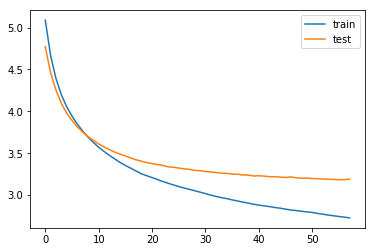

In [42]:
from matplotlib import pyplot
%matplotlib inline
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Next, let’s build the dictionary to convert the index to word for target and source vocabulary:**

In [43]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [44]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [45]:
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

**We are defining a function below which is the implementation of the inference process**

In [46]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

**Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:**


In [47]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

**Run the model over the data to see the results**

In [48]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: astronomers have discovered 72 galaxies using very large telescope vlt in chile as part of the deepest survey ever conducted vlt used an instrument which split light into its component colours to create spectrum this allows measurement of distance colours and other properties of galaxies which went undetected even by nasa hubble space telescope said astronomers 
Original summary: start single telescope discovers 72 new galaxies end 
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/ta

In [49]:
a="Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [50]:
import re

#Removes non-alphabetic characters:
def text_strip2(row):
        
    #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
    row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
    row=re.sub("(\\r)", ' ', str(row)).lower() 
    row=re.sub("(\\n)", ' ', str(row)).lower()
        
    row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
    row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
    row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
    row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
    row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
    row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
    row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
    row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
    row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
    row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
    row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
    row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
    row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
    row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
    #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
        repl_url = url.group(3)
        row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
    except:
        pass #there might be emails with no url in them
        

        
    row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
    #Should always be last
    row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
    yield row


In [51]:
a=  text_strip2(a)

In [52]:
from time import time
import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
b = [str(doc) for doc in nlp.pipe(a, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.0 mins


In [53]:
x_tokenizer.fit_on_texts(list(b))
b    =   x_tokenizer.texts_to_sequences(b)
b    =   pad_sequences(b,  maxlen=100, padding='post')

In [54]:
print("Predicted summary:",decode_sequence(np.array(b).reshape(1,100)))

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapD